In [249]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit
import re

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [423]:
df = pd.read_csv('/Users/xbno/Downloads/leftjoin.csv')
df['oc_hx_date'] = pd.to_datetime(df['oc_hx_date'])
df['s_hx_date'] = pd.to_datetime(df['s_hx_date'])
df.set_index(["oc_hx_date", "oc_hx_contract_symbol"], inplace=True)
df = df.sort_index()

In [490]:
df.dropna(axis=1)

oc_hx_symbol  oc_hx_hi  oc_hx_lo  oc_hx_open  \
oc_hx_date oc_hx_contract_symbol                                                
2019-01-02 FEYE210115C00015000           FEYE      4.80      4.80        4.80   
           FEYE210115C00017000           FEYE      3.90      3.90        3.90   
2019-01-04 FEYE210115C00015000           FEYE      5.10      5.09        5.10   
           FEYE210115C00017000           FEYE      4.31      3.83        4.20   
2019-01-14 FEYE210115C00015000           FEYE      5.25      5.09        5.25   
...                                       ...       ...       ...         ...   
2021-01-21 AMC210122C00003000             AMC      0.21      0.01        0.21   
           BB210122C00007000               BB      5.85      5.10        5.75   
2021-01-22 AMC210122C00002500             AMC      1.24      0.31        0.41   
           AMC210122C00003000             AMC      0.72      0.01        0.05   
           BB210122C00007000               BB      7.20      5.20        5.25   

                                  oc_hx_close s_hx_symbol  s_hx_hi  s_hx_lo  \
oc_hx_date oc_hx_contract_symbol                                              
2019-01-02 FEYE210115C00015000           4.80        FEYE   16.260    15.70   
           FEYE210115C00017000           3.90        FEYE   16.260    15.70   
2019-01-04 FEYE210115C00015000           5.10        FEYE   16.220    15.69   
           FEYE210115C00017000           4.20        FEYE   16.220    15.69   
2019-01-14 FEYE210115C00015000           5.15        FEYE   16.640    16.27   
...                                       ...         ...      ...      ...   
2021-01-21 AMC210122C00003000            0.09         AMC    3.060     2.85   
           BB210122C00007000             5.80          BB   12.945    12.01   
2021-01-22 AMC210122C00002500            1.00         AMC    3.740     2.81   
           AMC210122C00003000            0.50         AMC    3.740     2.81   
           BB210122C00007000             7.00          BB   14.280    12.17   

                                  s_hx_open  s_hx_close  s_hx_date  
oc_hx_date oc_hx_contract_symbol                                    
2019-01-02 FEYE210115C00015000        15.95       16.02 2019-01-02  
           FEYE210115C00017000        15.95       16.02 2019-01-02  
2019-01-04 FEYE210115C00015000        15.75       16.01 2019-01-04  
           FEYE210115C00017000        15.75       16.01 2019-01-04  
2019-01-14 FEYE210115C00015000        16.64       16.41 2019-01-14  
...                                     ...         ...        ...  
2021-01-21 AMC210122C00003000          3.00        2.98 2021-01-21  
           BB210122C00007000          12.62       12.85 2021-01-21  
2021-01-22 AMC210122C00002500          2.91        3.51 2021-01-22  
           AMC210122C00003000          2.91        3.51 2021-01-22  
           BB210122C00007000          12.37       14.04 2021-01-22  

[1099 rows x 11 columns]

### Random entry/exit from readme

Creates random entry/exit pairs. Overwrite and buy at first peak. Used to figure out proper format and play with structure.

In [428]:
rand = vbt.RAND.run(n=[i for i in range(df_tmp.shape[1])], input_shape=(df_tmp.shape[0],), seed=22)
entries = rand.entries
exits = rand.exits

entries.iloc[:,:] = False
entries.iloc[0,:] = True
exits.iloc[:,:] = False

### Create entry/exit for vectorbt

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [440]:
df.dropna(subset=['contract_symbol'])

contract_symbol    y_pred  purch_date  \
oc_hx_date oc_hx_contract_symbol                                              
2020-12-08 FEYE201218C00016000    FEYE201218C00016000  1.745762  2020-12-08   
           FEYE210115C00016000    FEYE210115C00016000  1.227066  2020-12-08   
           FEYE210115C00017000    FEYE210115C00017000  2.011813  2020-12-08   
2020-12-09 FEYE210115C00015000    FEYE210115C00015000  1.074493  2020-12-09   
2020-12-14 FEYE201224C00014000    FEYE201224C00014000  1.710953  2020-12-14   
2020-12-16 FEYE210115C00015000    FEYE210115C00015000  1.143350  2020-12-16   
2020-12-29 BB210122C00007000        BB210122C00007000  1.148013  2020-12-29   
2020-12-30 BB210108C00007000        BB210108C00007000  1.589424  2020-12-30   
2021-01-06 BB210122C00007000        BB210122C00007000  1.433161  2021-01-06   
2021-01-07 AMC210122C00003000      AMC210122C00003000  1.491769  2021-01-07   
2021-01-11 AMC210122C00002500      AMC210122C00002500  1.221654  2021-01-11   
2021-01-12 AMC210122C00002500      AMC210122C00002500  1.109983  2021-01-12   
2021-01-14 AMC210122C00003000      AMC210122C00003000  1.111632  2021-01-14   

                                           purch_datetime  trade_price  win  \
oc_hx_date oc_hx_contract_symbol                                              
2020-12-08 FEYE201218C00016000    2020-12-08 15:31:04.223         0.24  1.0   
           FEYE210115C00016000    2020-12-08 10:59:09.849         0.66  1.0   
           FEYE210115C00017000    2020-12-08 13:38:55.160         0.37  1.0   
2020-12-09 FEYE210115C00015000    2020-12-09 12:14:45.025         0.55  1.0   
2020-12-14 FEYE201224C00014000    2020-12-14 10:51:46.350         0.44  1.0   
2020-12-16 FEYE210115C00015000    2020-12-16 12:29:08.128         0.68  1.0   
2020-12-29 BB210122C00007000      2020-12-29 12:43:42.075         0.30  1.0   
2020-12-30 BB210108C00007000      2020-12-30 11:26:28.730         0.12  1.0   
2021-01-06 BB210122C00007000      2021-01-06 12:44:44.402         0.23  1.0   
2021-01-07 AMC210122C00003000     2021-01-07 09:40:02.642         0.07  1.0   
2021-01-11 AMC210122C00002500     2021-01-11 15:05:46.023         0.16  1.0   
2021-01-12 AMC210122C00002500     2021-01-12 11:49:20.641         0.19  1.0   
2021-01-14 AMC210122C00003000     2021-01-14 15:07:05.802         0.05  1.0   

                                  loss  close_day_of_exp    exp_pct  \
oc_hx_date oc_hx_contract_symbol                                      
2020-12-08 FEYE201218C00016000     0.0              3.12  12.000000   
           FEYE210115C00016000     0.0              6.05   8.166667   
           FEYE210115C00017000     0.0              5.40  13.594595   
2020-12-09 FEYE210115C00015000     0.0              7.00  11.727273   
2020-12-14 FEYE201224C00014000     0.0              8.20  17.636364   
2020-12-16 FEYE210115C00015000     0.0              7.00   9.294118   
2020-12-29 BB210122C00007000       0.0              7.00  22.333333   
2020-12-30 BB210108C00007000       0.0              0.55   3.583333   
2021-01-06 BB210122C00007000       0.0              7.00  29.434783   
2021-01-07 AMC210122C00003000      0.0              0.50   6.142857   
2021-01-11 AMC210122C00002500      0.0              1.00   5.250000   
2021-01-12 AMC210122C00002500      0.0              1.00   4.263158   
2021-01-14 AMC210122C00003000      0.0              0.50   9.000000   

                                  future_intra_hi  ...  oc_hx_hi  oc_hx_lo  \
oc_hx_date oc_hx_contract_symbol                   ...                       
2020-12-08 FEYE201218C00016000               3.76  ...      0.29      0.20   
           FEYE210115C00016000               9.53  ...      0.69      0.63   
           FEYE210115C00017000               8.50  ...      0.39      0.35   
2020-12-09 FEYE210115C00015000              10.50  ...      0.58      0.41   
2020-12-14 FEYE201224C00014000              10.80  ...      0.50      0.23   
2020-12-16 FEYE210115C00015000              10.50  ...

In [676]:
entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['contract_symbol'].last().unstack()
entry_df = entry_df.shift(1)
entry_df = entry_df.fillna(False)
entry_df = entry_df.replace({c:True for c in entry_df.columns})

In [662]:
assert entry_df.loc['2020-12-08'].all() == False  # original trade check
assert entry_df.loc['2020-12-09'].sum() == 3  # shifted check
assert (entry_df.loc['2020-12-09'][entry_df.loc['2020-12-09'] == True].index
    == 
    ['FEYE201218C00016000', 'FEYE210115C00016000', 'FEYE210115C00017000']).all()  # shifted check

In [663]:
def parse_contract_symbol(row):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"
    cs = row['contract_symbol']
    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

In [677]:
exit_df = entry_df.copy()
exit_df.iloc[:,:] = False

entry_exit_df = df.dropna(subset=['contract_symbol'])
entry_exit_df[['option_expiration','symbol','root','strike','type']] = entry_exit_df.apply(parse_contract_symbol,axis=1,result_type="expand")
# entry_exit_df.reset_index().groupby(['option_expiration','oc_hx_contract_symbol'])['contract_symbol'].last().unstack()
entry_exit_df = entry_exit_df[['contract_symbol','option_expiration','purch_date']].drop_duplicates()

for exit in entry_exit_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records'):
    exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [793]:
assert exit_df.sum().sum() == 9  # does this need to be 12?

### Setup wide data for vectorbt

One column per option_contract series

In [672]:
df_tmp = df[[c for c in df.columns if 'oc_hx' in c]]
df_tmp = df_tmp.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
df_tmp = df_tmp.sort_index()
df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])['oc_hx_close'].max().unstack().dropna(how='all')

In [673]:
assert df_tmp.shape == entry_df.shape == exit_df.shape

### Create vectorbt portfolio.from_orders()

Join entry_df and exit_df that had been created for the signals version to create +/- values for orders

In [812]:
# # https://github.com/polakowo/vectorbt/issues/89
# price = pd.Series([1., 2., 3.])
# entries = pd.Series([True, False, False])
# exits = pd.Series([False, False, True])
# size = entries.astype(int) - exits.astype(int)
# size[entries] = 0.5
# p = vbt.Portfolio.from_orders(price, size)#, size_type='targetpercent')
# p.shares()

In [822]:
entry_sz = entry_df.astype(int) * 10 * 100
exit_sz = exit_df.astype(int) * entry_sz.sum()
entry_exit_sz = entry_sz - exit_sz

In [823]:
symbol_groups = pd.Index([re.match('[A-Z]*',c)[0] for c in df_tmp.columns], name='group')
portfolio = vbt.Portfolio.from_orders(
    df_tmp, 
    size=entry_exit_sz, 
    min_size=0,
    max_size=10000, 
    group_by=symbol_groups, 
    log=True, 
    fees=0.001, 
    slippage=0.001,
    init_cash=10000,
#     cash_sharing=True, 
    freq='1D',
)

### Create vectorbt portfolio.from_signals()

Use groups to group by symbol instead of contract_symbol

In [796]:
# portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
symbol_groups = pd.Index([re.match('[A-Z]*',c)[0] for c in df_tmp.columns], name='group')
portfolio = vbt.Portfolio.from_signals(
    df_tmp, 
    entries=entry_df, 
    exits=exit_df, 
    min_size=5,
    max_size=10, 
    group_by=symbol_groups, 
    log=True, 
    fees=0.001, 
    slippage=0.001,
    
    size=1, 
    size_type='percent',
#     size=1, 
#     size_type='percent',  https://github.com/polakowo/vectorbt/issues/89
    
#     init_cash='autoalign', 
    init_cash=10000,
    cash_sharing=True, 
    freq='1D',
    accumulate=True,  # makes multiple orders stack
    
#     direction=[list(Direction) for _ in range(entry_df.shape[1])],
#     broadcast_kwargs=dict(columns_from=Direction._fields)

)

### Examine portfolio methods

In [801]:
portfolio.share_flow()
portfolio.shares()

oc_hx_contract_symbol,AMC210122C00002500,AMC210122C00003000,BB210108C00007000,BB210122C00007000,FEYE201218C00016000,FEYE201224C00014000,FEYE210115C00015000,FEYE210115C00016000,FEYE210115C00017000
oc_hx_date,,,,,,,,,
2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-01-15,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
2021-01-19,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
2021-01-20,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0


In [808]:
portfolio.cash_flow()
portfolio.cash()

group,AMC,BB,FEYE
oc_hx_date,,,
2019-01-02,20000.000000,20000.000000,50000.000000
2019-01-04,20000.000000,20000.000000,50000.000000
2019-01-14,20000.000000,20000.000000,50000.000000
2019-01-15,20000.000000,20000.000000,50000.000000
2019-01-18,20000.000000,20000.000000,50000.000000
...,...,...,...
2021-01-15,19994.589195,19997.973998,50347.125348
2021-01-19,19994.589195,19997.973998,50347.125348
2021-01-20,19994.589195,19997.973998,50347.125348


In [814]:
portfolio.daily_returns(group_by=None)

group,AMC,BB,FEYE
oc_hx_date,,,
2019-01-02,0.000000,0.000000,0.000000
2019-01-04,0.000000,0.000000,0.000000
2019-01-14,0.000000,0.000000,0.000000
2019-01-15,0.000000,0.000000,0.000000
2019-01-18,0.000000,0.000000,0.000000
...,...,...,...
2021-01-15,0.000335,0.000689,-0.000183
2021-01-19,0.000390,0.002403,0.000000
2021-01-20,-0.000240,0.000398,0.000000


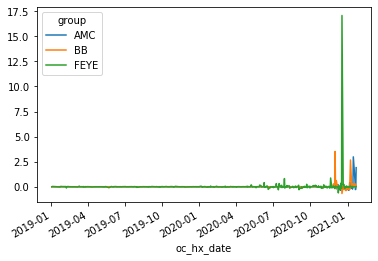

In [824]:
portfolio.market_returns().plot()

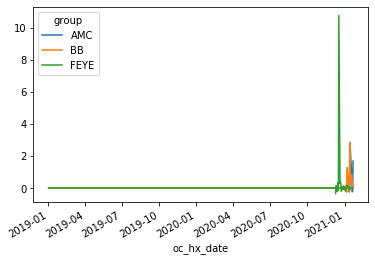

In [825]:
portfolio.active_returns().plot()

In [826]:
portfolio.cumulative_returns()

group,AMC,BB,FEYE
oc_hx_date,,,
2019-01-02,0.000000,0.000000,0.000000
2019-01-04,0.000000,0.000000,0.000000
2019-01-14,0.000000,0.000000,0.000000
2019-01-15,0.000000,0.000000,0.000000
2019-01-18,0.000000,0.000000,0.000000
...,...,...,...
2021-01-15,0.029946,0.278870,0.694251
2021-01-19,0.068946,0.519870,0.694251
2021-01-20,0.044946,0.559870,0.694251


In [827]:
portfolio.returns_stats()

Start                    2019-01-02 00:00:00
End                      2021-01-22 00:00:00
Duration                   440 days 00:00:00
Total Return [%]                     50.1789
Benchmark Return [%]                  215.39
Annual Return [%]                    25.6962
Annual Volatility [%]                21.7004
Sharpe Ratio                         1.13174
Calmar Ratio                         7.71315
Max. Drawdown [%]                   -6.31379
Omega Ratio                          9.48925
Sortino Ratio                        11.0617
Skew                                 13.3404
Kurtosis                             214.147
Tail Ratio                               inf
Common Sense Ratio                       inf
Value at Risk                              0
Alpha                               0.156024
Beta                               0.0195026
Name: <lambda>, dtype: object

In [828]:
portfolio.final_value()

group
AMC     22452.92246
BB      33769.41380
FEYE    84712.53479
dtype: float64

In [829]:
portfolio.value_at_risk()

group
AMC     0.0
BB      0.0
FEYE    0.0
dtype: float64

In [830]:
portfolio.total_market_return()

group
AMC    -0.476869
BB      3.764286
FEYE    3.174293
dtype: float64

In [831]:
portfolio.total_profit()

group
AMC      2452.92246
BB      13769.41380
FEYE    34712.53479
dtype: float64

In [832]:
portfolio.calmar_ratio()

group
AMC      1.830632
BB      18.663257
FEYE     2.645566
dtype: float64

In [833]:
# portfolio.get_drawdowns()
portfolio.max_drawdown(group_by=False)
# portfolio.drawdown()

oc_hx_contract_symbol
AMC210122C00002500    -0.025502
AMC210122C00003000    -0.050003
BB210108C00007000     -0.005020
BB210122C00007000     -0.036735
FEYE201218C00016000   -0.005014
FEYE201224C00014000   -0.097630
FEYE210115C00015000   -0.202236
FEYE210115C00016000   -0.143500
FEYE210115C00017000   -0.152418
dtype: float64

In [834]:
portfolio.value(group_by=False).vbt.plot()

FigureWidget({
    'data': [{'name': 'AMC210122C00002500',
              'showlegend': True,
              'ty…

In [835]:
portfolio.value().vbt.plot()

FigureWidget({
    'data': [{'name': 'AMC',
              'showlegend': True,
              'type': 'scatter',…

In [836]:
portfolio.total_return(group_by=False)

oc_hx_contract_symbol
AMC210122C00002500     0.175552
AMC210122C00003000     0.069740
BB210108C00007000      0.044870
BB210122C00007000      1.332071
FEYE201218C00016000    0.304362
FEYE201224C00014000    0.771267
FEYE210115C00015000    1.306019
FEYE210115C00016000    0.571727
FEYE210115C00017000    0.517879
dtype: float64

In [837]:
portfolio.total_return()

group
AMC     0.122646
BB      0.688471
FEYE    0.694251
dtype: float64

### change t his to multiple entries per day

In [840]:
trade_df = portfolio.logs.records

In [842]:
trade_df[trade_df['order_id'] != -1]

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
432,432,432,0,0,10000.00000,0.0,0.14,10000.00000,1000.0,0,...,True,9859.71986,1000.0,1000.0,0.14014,0.14014,0,0,-1,0
433,433,433,0,0,9859.71986,1000.0,0.10,9959.71986,1000.0,0,...,True,9759.51976,2000.0,1000.0,0.10010,0.10010,0,0,-1,1
439,439,439,0,0,9759.51976,2000.0,1.00,11759.51976,-2000.0,0,...,True,11755.52176,0.0,2000.0,0.99900,1.99800,1,0,-1,2
870,870,430,1,1,10000.00000,0.0,0.09,10000.00000,1000.0,0,...,True,9909.81991,1000.0,1000.0,0.09009,0.09009,0,0,-1,3
875,875,435,1,1,9909.81991,1000.0,0.21,10119.81991,1000.0,0,...,True,9699.39970,2000.0,1000.0,0.21021,0.21021,0,0,-1,4
879,879,439,1,1,9699.39970,2000.0,0.50,10699.39970,-2000.0,0,...,True,10697.40070,0.0,2000.0,0.49950,0.99900,1,0,-1,5
1305,1305,425,2,2,10000.00000,0.0,0.10,10000.00000,1000.0,0,...,True,9899.79990,1000.0,1000.0,0.10010,0.10010,0,0,-1,6
1310,1310,430,2,2,9899.79990,1000.0,0.55,10449.79990,-1000.0,0,...,True,10448.70045,0.0,1000.0,0.54945,0.54945,1,0,-1,7
1744,1744,424,3,3,10000.00000,0.0,0.27,10000.00000,1000.0,0,...,True,9729.45973,1000.0,1000.0,0.27027,0.27027,0,0,-1,8
1749,1749,429,3,3,9729.45973,1000.0,0.38,10109.45973,1000.0,0,...,True,9348.69935,2000.0,1000.0,0.38038,0.38038,0,0,-1,9


In [843]:
portfolio.value()

group,AMC,BB,FEYE
oc_hx_date,,,
2019-01-02,20000.00000,20000.0000,50000.00000
2019-01-04,20000.00000,20000.0000,50000.00000
2019-01-14,20000.00000,20000.0000,50000.00000
2019-01-15,20000.00000,20000.0000,50000.00000
2019-01-18,20000.00000,20000.0000,50000.00000
...,...,...,...
2021-01-15,20598.91946,25577.3998,84712.53479
2021-01-19,21378.91946,30397.3998,84712.53479
2021-01-20,20898.91946,31197.3998,84712.53479


In [485]:
# portfolio.plot(column='BTC-USD')
# portfolio.plot(index='BTC-USD')
portfolio.stats()

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:232: RuntimeWarning:

invalid value encountered in true_divide



Start                     2019-01-02 00:00:00
End                       2021-01-22 00:00:00
Duration                    440 days 00:00:00
Init. Cash                            30.3266
Total Profit                          12.1492
Total Return [%]                      40.0613
Benchmark Return [%]                   215.39
Position Coverage [%]                 9.90909
Max. Drawdown [%]                     26.7313
Avg. Drawdown [%]                     8.07786
Max. Drawdown Duration      233 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
Num. Trades                           5.33333
Win Rate [%]                             37.5
Best Trade [%]                        3734.53
Worst Trade [%]                      -70.6028
Avg. Trade [%]                        328.759
Max. Trade Duration         123 days 00:00:00
Avg. Trade Duration          40 days 21:00:00
Expectancy                            2.27798
SQN                                  0.821658
Gross Exposure                    

In [83]:
symbols = ["BTC-USD", "ETH-USD", "LTC-USD"]
price_by_symbol = vbt.utils.data.download(symbols, start=start_date, end=end_date, cols='Close')
price = vbt.utils.data.concat_symbols(price_by_symbol, treat_missing='drop')

# windows = np.arange(2, 4)
# fast_ma, slow_ma = vbt.MA.run_combs(price, window=windows, r=2, short_names=['fast', 'slow'])
# entries = fast_ma.ma_above(slow_ma, crossover=True)
# exits = fast_ma.ma_below(slow_ma, crossover=True)

portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price, entries, exits, **portfolio_kwargs)

fig = portfolio.total_return().vbt.heatmap(
    x_level='fast_window', y_level='slow_window', slider_level='symbol', symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()

In [369]:
# portfolio["BTC-USD"].total_profit()
portfolio.total_profit(group_by=False)

rand_n  oc_hx_contract_symbol
0       AMC210122C00002500        4.248499
1       AMC210122C00003000        2.199400
2       BB210108C00007000         2.148799
3       BB210122C00007000        33.446898
4       FEYE201218C00016000      14.397599
5       FEYE201224C00014000      39.396798
6       FEYE210115C00015000      32.645298
7       FEYE210115C00016000      26.993497
8       FEYE210115C00017000      25.146298
dtype: float64

In [370]:
entries.shape

(440, 9)

In [376]:
portfolio.get_trades().count()

group
AMC     2
BB      2
FEYE    5
dtype: int64

In [377]:
portfolio.trades.expectancy()

group
AMC      3.223949
BB      16.723449
FEYE     0.000000
dtype: float64

In [378]:
portfolio.order_records

array([(0, 429, 1, 5., 0.06006, 0.0003003 , 0),
       (1, 431, 0, 5., 0.15015, 0.00075075, 0),
       (2, 423, 3, 5., 0.31031, 0.00155155, 0),
       (3, 424, 2, 5., 0.12012, 0.0006006 , 0),
       (4, 409, 4, 5., 0.24024, 0.0012012 , 0),
       (5, 409, 7, 5., 0.65065, 0.00325325, 0),
       (6, 409, 8, 5., 0.37037, 0.00185185, 0),
       (7, 410, 6, 5., 0.47047, 0.00235235, 0),
       (8, 413, 5, 5., 0.32032, 0.0016016 , 0)],
      dtype={'names':['id','idx','col','size','price','fees','side'], 'formats':['<i8','<i8','<i8','<f8','<f8','<f8','<i8'], 'offsets':[0,8,16,24,32,40,48], 'itemsize':56, 'aligned':True})

In [379]:
portfolio.orders.buy.count()

group
AMC     2
BB      2
FEYE    5
dtype: int64

In [380]:
price.head()

symbol,BTC-USD,ETH-USD,LTC-USD
Date,,,
2020-12-15,19417.076172,589.355591,81.400673
2020-12-16,21310.597656,636.181824,92.789688
2020-12-17,22805.162109,642.868958,100.959572
2020-12-18,23137.960938,654.811951,109.384506
2020-12-19,23869.832031,659.297913,120.558907


In [381]:
portfolio.value().vbt.plot()

FigureWidget({
    'data': [{'name': 'AMC',
              'showlegend': True,
              'type': 'scatter',…

In [382]:
portfolio.total_profit(group_by=False)

rand_n  oc_hx_contract_symbol
0       AMC210122C00002500        4.248499
1       AMC210122C00003000        2.199400
2       BB210108C00007000         2.148799
3       BB210122C00007000        33.446898
4       FEYE201218C00016000      14.397599
5       FEYE201224C00014000      39.396798
6       FEYE210115C00015000      32.645298
7       FEYE210115C00016000      26.993497
8       FEYE210115C00017000      25.146298
dtype: float64

## vectorbt: Random search

### One-time allocation

In [14]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [15]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0,   'FB'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1,   'FB'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998,   'FB'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999,   'FB'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [16]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(37, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [17]:
%%time
# Run simulation
portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(portfolio.orders))

10000
CPU times: user 5.27 s, sys: 98.1 ms, total: 5.37 s
Wall time: 5.65 s


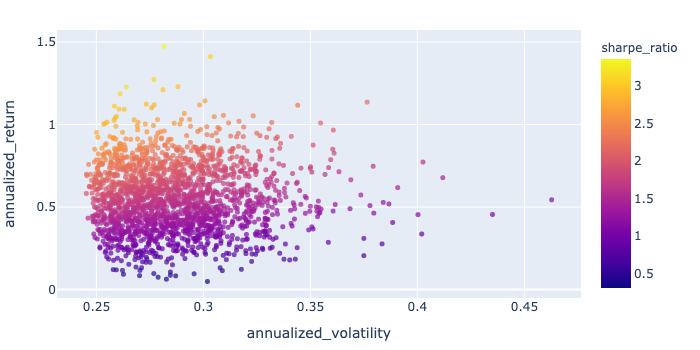

In [18]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = portfolio.annualized_return()
annualized_return.index = portfolio.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=portfolio.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_png()

In [19]:
# Get index of the best group according to the target metric
best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(best_symbol_group)

1636


In [20]:
# Print best weights
print(weights[best_symbol_group])

[0.00448558 0.10106375 0.0455881  0.65801902 0.19084355]


In [21]:
# Compute default stats
print(portfolio.iloc[best_symbol_group].stats())

Start                     2020-12-15 00:00:00
End                       2021-02-08 00:00:00
Duration                     37 days 00:00:00
Init. Cash                                100
Total Profit                           14.217
Total Return [%]                       14.217
Benchmark Return [%]                  6.55174
Position Coverage [%]                     100
Max. Drawdown [%]                     4.95296
Avg. Drawdown [%]                     2.77898
Max. Drawdown Duration        8 days 00:00:00
Avg. Drawdown Duration        5 days 19:12:00
Num. Trades                                 5
Win Rate [%]                               80
Best Trade [%]                        18.3927
Worst Trade [%]                      -3.25531
Avg. Trade [%]                        6.55174
Max. Trade Duration          36 days 00:00:00
Avg. Trade Duration          36 days 00:00:00
Expectancy                             2.8434
SQN                                    1.2221
Gross Exposure                    

### Rebalance monthly

In [22]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

3


In [23]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(37, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [21]:
%%time

# Run simulation, with rebalancing monthly
rb_portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto',  # important: sell before buy
    freq='D',
    incl_unrealized=True
)

print(len(rb_portfolio.orders))

499993
CPU times: user 500 ms, sys: 40.3 ms, total: 541 ms
Wall time: 544 ms


In [22]:
rb_best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1920


In [23]:
print(weights[rb_best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [24]:
print(rb_portfolio.iloc[rb_best_symbol_group].stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  376.316
Total Return [%]                              376.316
Benchmark Return [%]                          274.226
Position Coverage [%]                             100
Max. Drawdown [%]                             33.6883
Avg. Drawdown [%]                             2.83032
Max. Drawdown Duration              304 days 00:00:00
Avg. Drawdown Duration     12 days 06:29:11.351351351
Num. Trades                                       114
Win Rate [%]                                  99.1228
Best Trade [%]                                249.176
Worst Trade [%]                              -7.13426
Avg. Trade [%]                                65.8767
Max. Trade Duration                1030 days 00:00:00
Avg. Trade Duration       53

In [26]:
def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    (rb_holding_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        shapes=[dict(
            xref='x',
            yref='paper',
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            line_color=vbt.settings.layout['template']['layout']['plot_bgcolor']
        ) for date in price.index[rb_idxs]]
    ).show_png()

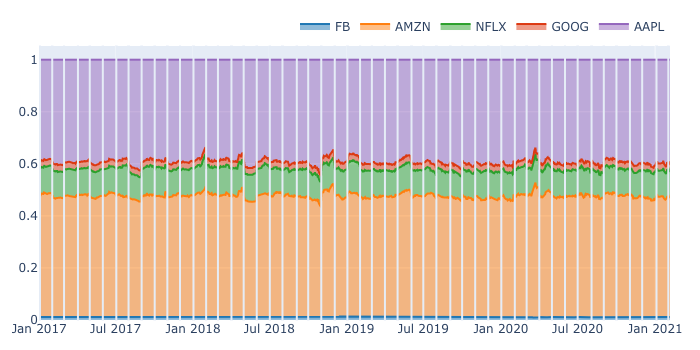

In [26]:
plot_allocation(rb_portfolio.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [20]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def prep_func_nb(simc, every_nth):
    # Define rebalancing days
    simc.active_mask[:, :] = False
    simc.active_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(sc, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(sc.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def segment_prep_func_nb(sc, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    auto_call_seq_ctx_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)

@njit
def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=oc.close[oc.i, oc.col]
    )

In [21]:
ann_factor = returns.vbt.returns(freq='D').ann_factor

In [37]:
%%time
# Run simulation using a custom order function
srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 85.6 ms, sys: 2.52 ms, total: 88.1 ms
Wall time: 104 ms


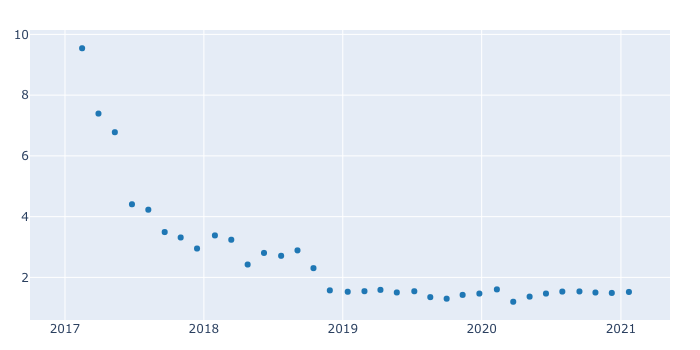

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [31]:
print(srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  213.654
Total Return [%]                              213.654
Benchmark Return [%]                          274.226
Position Coverage [%]                         97.0902
Max. Drawdown [%]                             34.3509
Avg. Drawdown [%]                             3.30605
Max. Drawdown Duration              311 days 00:00:00
Avg. Drawdown Duration     15 days 04:19:40.327868852
Num. Trades                                        91
Win Rate [%]                                  80.2198
Best Trade [%]                                77.0805
Worst Trade [%]                              -23.7438
Avg. Trade [%]                                14.2463
Max. Trade Duration                1000 days 00:00:00
Avg. Trade Duration       52

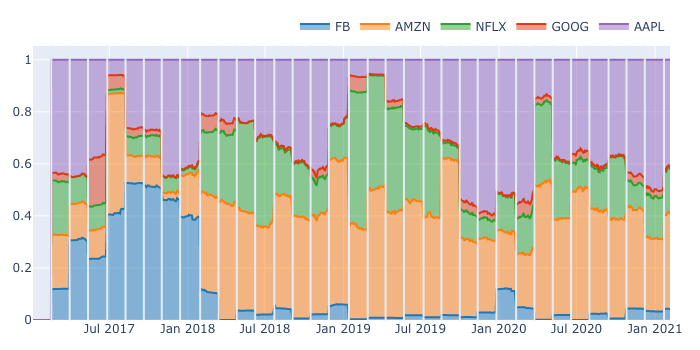

In [32]:
plot_allocation(srb_portfolio)

You can see how weights stabilize themselves with growing data.

In [33]:
%%time
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 51.4 ms, sys: 1.21 ms, total: 52.6 ms
Wall time: 53.2 ms


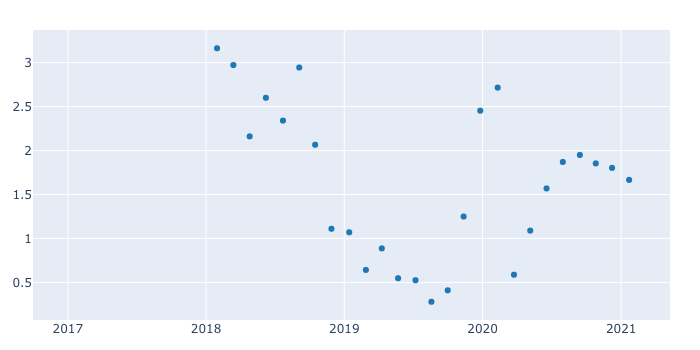

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [35]:
print(srb252_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  132.863
Total Return [%]                              132.863
Benchmark Return [%]                          274.226
Position Coverage [%]                         73.8118
Max. Drawdown [%]                              33.136
Avg. Drawdown [%]                             4.22363
Max. Drawdown Duration              193 days 00:00:00
Avg. Drawdown Duration     16 days 07:38:10.909090909
Num. Trades                                        61
Win Rate [%]                                  72.1311
Best Trade [%]                                89.0979
Worst Trade [%]                              -15.5016
Avg. Trade [%]                                11.4349
Max. Trade Duration                 760 days 00:00:00
Avg. Trade Duration       44

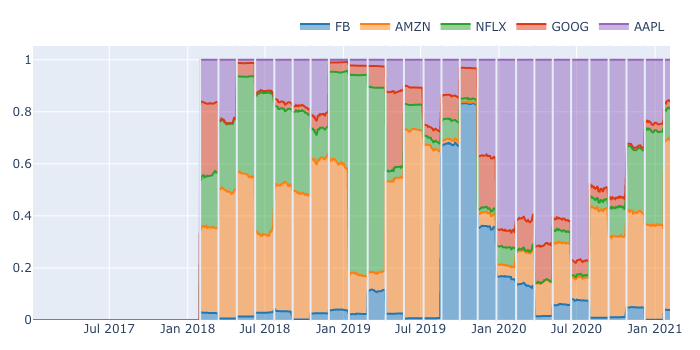

In [36]:
plot_allocation(srb252_portfolio)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [12]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.40827 0.04964 0.      0.54209]


In [13]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1031, 5)


In [14]:
%%time
# Run simulation with weights from PyPortfolioOpt
pyopt_portfolio = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
)

print(len(pyopt_portfolio.orders))

3
CPU times: user 154 ms, sys: 9.88 ms, total: 164 ms
Wall time: 147 ms


Faster than stacking solution, but doesn't let you compare weights.

In [15]:
print(pyopt_portfolio.stats())

Start                     2017-01-03 00:00:00
End                       2021-02-05 00:00:00
Duration                   1031 days 00:00:00
Init. Cash                                100
Total Profit                          373.014
Total Return [%]                      373.014
Benchmark Return [%]                  274.226
Position Coverage [%]                      60
Max. Drawdown [%]                     34.8417
Avg. Drawdown [%]                     2.64072
Max. Drawdown Duration      294 days 00:00:00
Avg. Drawdown Duration       11 days 12:00:00
Num. Trades                                 3
Win Rate [%]                              100
Best Trade [%]                        398.035
Worst Trade [%]                       332.026
Avg. Trade [%]                        358.279
Max. Trade Duration        1030 days 00:00:00
Avg. Trade Duration        1030 days 00:00:00
Expectancy                            124.338
SQN                                    2.1396
Gross Exposure                    

### Search and rebalance monthly

**NOTE:** PyPortfolioOpt cannot run within Numba, so restart the notebook and disable Numba in the first cell.

In [16]:
def pyopt_find_weights(sc, price, num_tests):
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [22]:
%%time
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function (Numba should be disabled)
pyopt_srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 716 ms, sys: 12.5 ms, total: 729 ms
Wall time: 790 ms


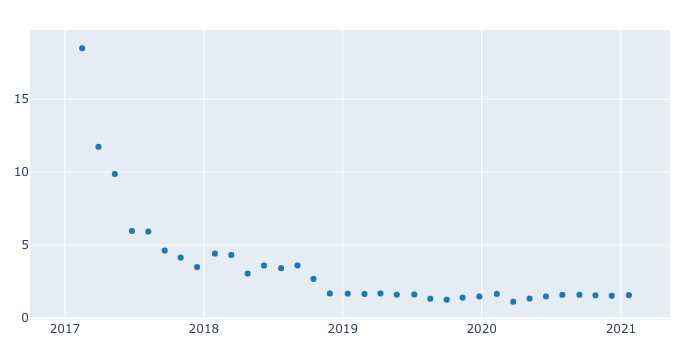

In [23]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [24]:
print(pyopt_srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  183.479
Total Return [%]                              183.479
Benchmark Return [%]                          274.226
Position Coverage [%]                         57.6722
Max. Drawdown [%]                             35.3639
Avg. Drawdown [%]                             3.63738
Max. Drawdown Duration              348 days 00:00:00
Avg. Drawdown Duration     16 days 19:42:51.428571428
Num. Trades                                        58
Win Rate [%]                                  84.4828
Best Trade [%]                                68.4189
Worst Trade [%]                              -30.6354
Avg. Trade [%]                                17.2885
Max. Trade Duration                 790 days 00:00:00
Avg. Trade Duration       24

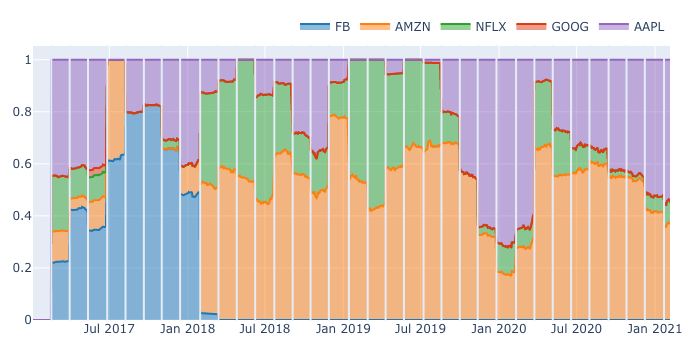

In [27]:
plot_allocation(pyopt_srb_portfolio)